In [1]:
import numpy as np
import seaborn as sns
from scipy.stats import bernoulli, halfnorm, norm, gamma, invgamma, cauchy
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

## Simulate data

Simulate data from the following model but include 11 NCOs but no outcome with causal associations with treatment A:

<div>
<img src="dag-1.png" width="500"/>
</div>

Since there is no observed confounder, we can estimate the average causal effects and biases using difference in means or ratios of means. One NCO is excluded from fitting the model to use for checking the posterior predictive.

In [55]:
# Set random seed
np.random.seed(42)
# Set number of observations
n = 1000
# Set number of unobserved confounders
p_u = 1
# Set number of treatment groups
n_a = 3
# Set number of scenarios/treatment contrasts
K = math.comb(n_a, 2)

# Generate latent space regression coefficients of U on A
alpha_u = np.random.uniform(0.25, 0.5, p_u)  # effect of U on treatment assigment A

# Generate unobserved confounder from standard normal
U = np.random.normal(size=(n, p_u))
# Generate another dataset with 1M samples to approximate the truth
U_1m = np.random.normal(size=(1000000, p_u))

# Define the treatment groups by discretizing the latent A according to quantiles
A = np.matmul(U, alpha_u)
# Add observation noise
A = A + np.random.normal(0, 1, size=n)
A_1m = np.matmul(U_1m, alpha_u) + np.random.normal(0, 1, size=len(U_1m))
# Generate the categorical treatment A using a probit model
A_obs = np.digitize(A, np.quantile(A_1m, np.linspace(0, 1, n_a+1))[0:n_a], right=False)
A_obs_1m = np.digitize(A_1m, np.quantile(A_1m, np.linspace(0, 1, n_a+1))[0:n_a], right=False)
# Reindex to start at 0
A_obs -= min(A_obs_1m)
A_obs_1m -= min(A_obs_1m)

# Create one-hot-encoding of A_obs: n \times n_a
unique_values = np.unique(A_obs_1m)
identity_matrix = np.eye(len(unique_values))
A_encoded = identity_matrix[np.searchsorted(unique_values, A_obs)]

In [92]:
# Define number of NCOs
I = 10

# Define the effects of U on the NCOs in latent space
beta_u_low = 0.5
beta_u_high = 1
theta_u = np.random.uniform(beta_u_low, beta_u_high, size=(p_u, I))

# Randomly zero-out the effects
# theta_u *= np.random.choice([0, 1], size=(p_u, I+1))

# Randomly shuffle the sign of the effects with probability 0.5
# theta_u *= np.random.choice([-1, 1], size=(p_u, I+1))

# Generate the latent NCOs
noise_se = 0.1 #np.random.uniform(0.5, 1.5, size=I+1)
N_1m = np.matmul(U_1m, theta_u) + np.random.normal(0, noise_se, size=(len(U_1m), I)) # use large sample of 1M observations to approx true bias
N = np.matmul(U, theta_u) + np.random.normal(0, noise_se, size=(n, I))

# Discretize the latent NCOs
h = np.diagonal(np.quantile(N_1m, np.linspace(0.05, 0.9, I), axis=0))
# h = 0
N_obs_1m = 1*(N_1m < h)
N_obs = 1*(N < h)

# Calculate the difference in means or biases
bias_N_true = [] # based on 1M samples
rd_N = []
rr_N = []
for i in range(n_a-1):
    for j in range(i+1, n_a):
        rd_N.append(np.mean(N_obs[A_obs == j,:], axis=0) - np.mean(N_obs[A_obs == i,:], axis=0))
        rr_N.append(np.mean(N_obs[A_obs == j,:], axis=0) / np.mean(N_obs[A_obs == i,:], axis=0))
rd_N = np.array(rd_N).transpose()
rr_N = np.array(rr_N).transpose()
lrr_N = np.log(rr_N)
rr_N

array([[0.28225806, 0.16452991, 0.58290598],
       [0.41258463, 0.25999789, 0.63016863],
       [0.49407224, 0.32249738, 0.65273326],
       [0.55439377, 0.44782395, 0.80777234],
       [0.71441589, 0.52054662, 0.72863248],
       [0.74614306, 0.58499525, 0.78402559],
       [0.79362937, 0.59845749, 0.75407679],
       [0.84677419, 0.69925214, 0.82578348],
       [0.87061838, 0.78245755, 0.89873769],
       [0.97412749, 0.88048773, 0.9038732 ]])

In [93]:
# Define function for statistics: s.e. for the biases
def get_boostrap_rd(indices, ncos, treatment, n):
    b_ncos = ncos[indices, :]
    b_treatment = treatment[indices]
    b_bias = []
    for i in range(n-1):
        for j in range(i+1, n):
            b_bias.append(np.mean(b_ncos[b_treatment==j,:], axis=0) - np.mean(b_ncos[b_treatment==i,:], axis=0))
    return np.array(b_bias).transpose()

def get_boostrap_rr(indices, ncos, treatment, n):
    b_ncos = ncos[indices, :]
    b_treatment = treatment[indices]
    b_bias = []
    for i in range(n-1):
        for j in range(i+1, n):
            b_bias.append(np.mean(b_ncos[b_treatment==j,:], axis=0) / np.mean(b_ncos[b_treatment==i,:], axis=0))
    return np.array(b_bias).transpose()

def get_boostrap_lrr(indices, ncos, treatment, n):
    b_ncos = ncos[indices, :]
    b_treatment = treatment[indices]
    b_bias = []
    for i in range(n-1):
        for j in range(i+1, n):
            b_bias.append(np.mean(b_ncos[b_treatment==j,:], axis=0) / np.mean(b_ncos[b_treatment==i,:], axis=0))
    return np.log(np.array(b_bias).transpose())

# Set the number of bootstrap samples
n_bootstrap = 100
# Create random sample with replacement of row indinces
b_indices = np.random.choice(range(n), size=(n_bootstrap, n), replace=True)
# Apply statistics to bootstrapped samples
b_rd = np.apply_along_axis(get_boostrap_rd, axis=1, arr=b_indices, ncos=N_obs, treatment=A_obs, n=n_a)
b_rr = np.apply_along_axis(get_boostrap_rr, axis=1, arr=b_indices, ncos=N_obs, treatment=A_obs, n=n_a)
b_lrr = np.apply_along_axis(get_boostrap_lrr, axis=1, arr=b_indices, ncos=N_obs, treatment=A_obs, n=n_a)
# Calculate s.e. of statistics in bootstrap samples
se_rd_N = np.std(b_rd, axis=0, ddof=1)
se_rr_N = np.std(b_rr, axis=0, ddof=1)
se_lrr_N = np.std(b_lrr, axis=0, ddof=1)
se_rd_N

array([[0.01841074, 0.0180565 , 0.0115163 ],
       [0.02948791, 0.02743255, 0.02361854],
       [0.03133456, 0.02946078, 0.03091352],
       [0.03162543, 0.03311625, 0.03405277],
       [0.03654073, 0.03777214, 0.03594426],
       [0.03414138, 0.04158195, 0.03507003],
       [0.02998063, 0.0382174 , 0.03795425],
       [0.03231567, 0.0389217 , 0.03716305],
       [0.02707166, 0.03053566, 0.03084921],
       [0.0199623 , 0.02401087, 0.02469987]])

In [94]:
# Define the correct delta: all zero because U has an effect on each NCO
true_delta = 1*(theta_u[0, :I] == 0)
# True scenario mean bias
# true_beta = np.abs(se_rd_N[:I,][true_delta==0,]).mean(axis=0)
# Define the correct M: sign of the effect of U on NCOs
true_M = (np.sign(theta_u[:,:I]) + 1) // 2
true_M = true_M.reshape((10,))
print(true_delta.mean())
print(true_M.mean())
# print(true_beta)

0.0
1.0


In [102]:
# Convert matrix of biases to dataframe
data_columns = ['setting_' + str(i) for i in range(K)]
data_index = ['nco_' + str(i) for i in range(I)]
data = pd.DataFrame(rd_N, columns=data_columns)
data['nco'] = data_index
data_long = pd.melt(data,
                    id_vars=['nco'],
                    value_vars=data_columns, 
                    var_name='setting', value_name='rd')
data_long['se_rd'] = se_rd_N.flatten('F')
data_long['se_rr'] = se_rr_N.flatten('F')
data_long['se_lrr'] = se_lrr_N.flatten('F')
data_long['rr'] = rr_N.flatten('F')
data_long['lrr'] = lrr_N.flatten('F')
data_long['prevalence'] = np.tile(np.linspace(0.05, 0.9, I), K)
print(data_long.head(3))

     nco    setting        rd     se_rd     se_rr    se_lrr        rr  \
0  nco_0  setting_0 -0.074571  0.018411  0.091282  0.333413  0.282258   
1  nco_1  setting_0 -0.154483  0.029488  0.078045  0.185248  0.412585   
2  nco_2  setting_0 -0.192187  0.031335  0.063582  0.124861  0.494072   

        lrr  prevalence  
0 -1.264934    0.050000  
1 -0.885314    0.144444  
2 -0.705074    0.238889  


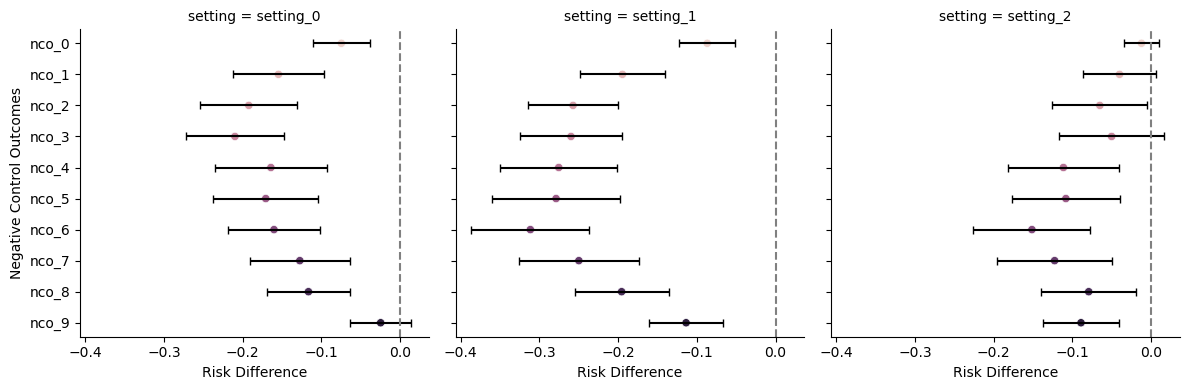

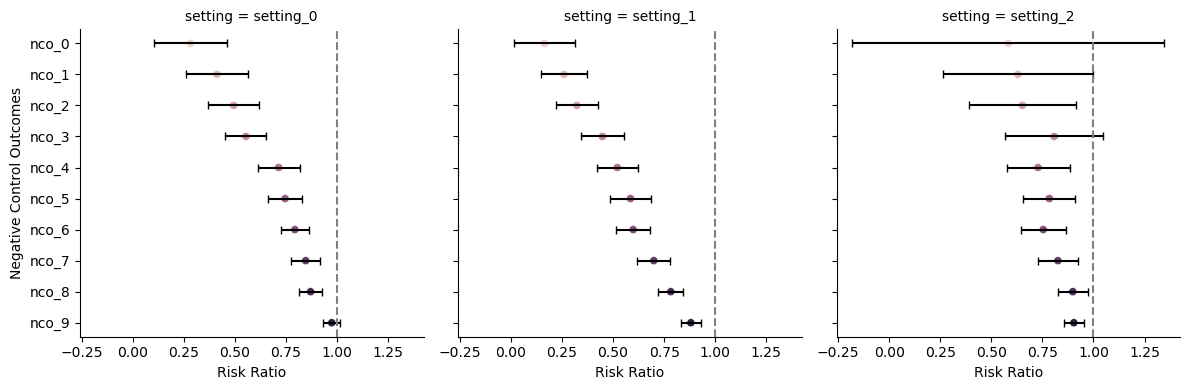

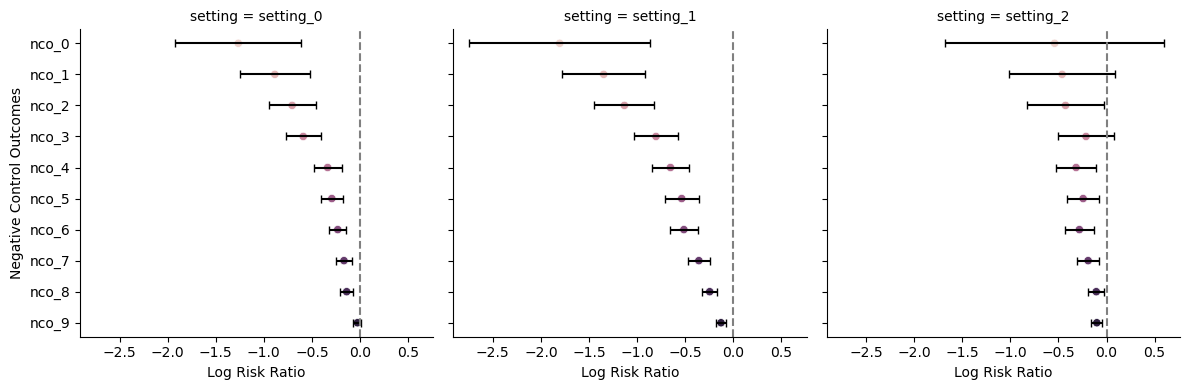

In [108]:
for col, title in zip(['rd', 'rr', 'lrr'], ['Risk Difference', 'Risk Ratio', 'Log Risk Ratio']):
    # Initialize a facet grid plot
    g = sns.FacetGrid(data_long, col='setting', height=4, aspect=1)

    # Create the scatter plot of the simulated data
    g.map(sns.scatterplot, col, 'nco', 'prevalence', alpha=1)

    # Function to add error bars
    def add_error_bars(x, y, error, **kwargs):
        data = kwargs.pop("data")
        ax = plt.gca()
        for i, (_, row) in enumerate(data.iterrows()):
            ax.errorbar(row[col], row['nco'], xerr=1.96*row['se_'+col], 
                        fmt='none', ecolor='black', capsize=3)

    # Add error bars faceted by 'type'
    g.map_dataframe(add_error_bars, 'bias', 'nco', 'se')

    # Add verticle line at 0.0
    if col=='rr':
        g.refline(x=1.0)
    else:
        g.refline(x=0.0)

    # Change x axis label
    g.set_axis_labels(title, "Negative Control Outcomes")

    # Show the plot
    plt.show()

If outcomes are dependent, needs to inflate the variance. Add grouping to the outcomes.

# Real data

Use LOOV, fit the model on all but one NCO and does posterior predictive on that NCO. Average the number of times posterior predictive covers the observed bias.